# Zillow House Tax Values

## Imports

In [1]:
# import data tools
import numpy as np
import pandas as pd

import wrangle as w
import explore as e
import modeling as m

import matplotlib.pyplot as plt
import seaborn as sns

## Acquire

* Data was acquired from the Codeup database
* The data was initially 52320 rows and 11 columns
* Each row represents one house that had a transaction in 2017
* Each column represents one aspect of the house

In [2]:
# Importing data and first cleaning
train, validate, test = w.wrangle_zillow()

opening data from local file


## Prepare

* List steps taken to clean your data here
* In particular call out how you handle null values and outliers in detail
* You must do this even if you do not do anything or do not encounter any
* After cleaning there were 45,517 rows of data

The dataset contains the variable fips, which translates to:
- 6037 - Los Angeles County, California
- 6059 - Orange County, California
- 6111 - Ventura County, California

In [3]:
# Spliting data and imputing missing values
train_scaled, validate_scaled, test_scaled = w.impute_and_scale(train, validate, test)

## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

## You may use this as a template for how to ask and answer each question:

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

# Does the number of cars that fit in the garage have a correlation to the tax value of the house?

# Hypothesis
cars_garage has a linear correlation to tax_value
- H$_0$: There is no linear correlation between cars_garage and tax_value
- H$_a$: There is a linear correlation between cars_garage and tax_value
- Confidence interval / alpha: 95% / 0.05
- This will be a pearsonsr correlation test

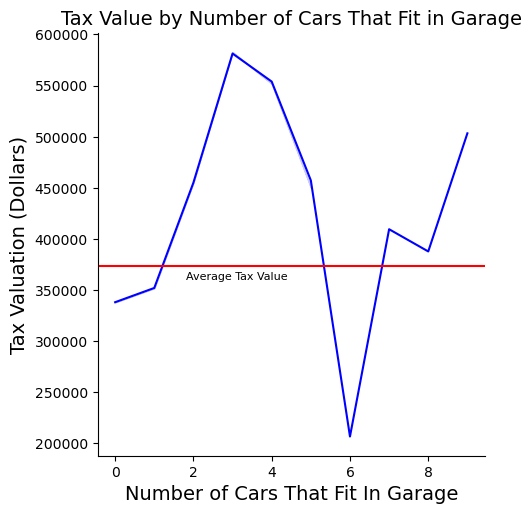

In [4]:
e.get_cars_value(train)

In [5]:
e.get_pearson_garage(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.24177353734407273


There is enough evidence to show that there is a linear correlation between cars_garage and tax_value, with a r coeficient of 0.24

## Does the square footage of the house have a linear correlation witih tax value?

## Hypothesis
Is there a linear corellation between the square footage (area) of the house and the tax value?
- H$_0$: There is no correlation between area and tax value
- H$_a$: There is a linear correlation between area and tax value
- alpha: 0.05
- This will be a pearsonsr test

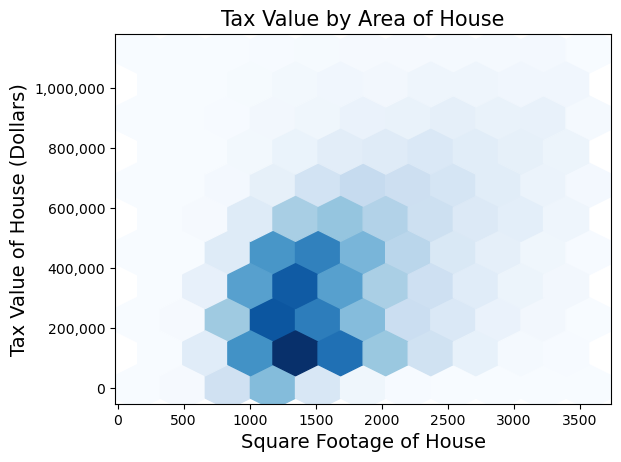

In [6]:
e.get_area_value(train)

In [7]:
e.get_pearson_area(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.45028158739912466


There is enough evidence to show that there is a linear relationship between the square footage (area) of the house and the tax value.

## Exploration Summary
* After your explore section, before you start modeling, provide a summary of your findings in Explore
* Include a summary of your take-aways
* Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you are using to model on

## Modeling

### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [8]:
# setup datasets for modeling
drops = ['tax_value','lot_size_binned']
X_train_scaled = train_scaled.drop(columns=drops)
y_train = pd.DataFrame(train_scaled.tax_value)
X_validate_scaled = validate_scaled.drop(columns=drops)
y_validate = pd.DataFrame(validate_scaled.tax_value)
X_test_scaled = test_scaled.drop(columns=drops)
y_test = pd.DataFrame(test_scaled.tax_value)
# list the chosen features to use
f_features = ['pools', 'year_built', 'area', 'garage_sqft', 'region']

In [9]:
m.get_baseline_model(y_train)

Baseline Model (mean)
RMSE for baseline model: 243722.13
R^2 for baseline model: 0.0


### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [10]:
lars = m.get_lars_model(X_train_scaled, y_train, 
                   X_validate_scaled, y_validate, f_features)

Lasso + Lars Model
RMSE on training data: 215268.7
RMSE on validation data: 219013.26
Difference in RMSE: 3744.5551
R^2 value: 0.2082


In [11]:
glm = m.get_tweedie_model(X_train_scaled, y_train, 
                      X_validate_scaled, y_validate, f_features)

Tweedie Model
RMSE on training data: 243722.13
RMSE on validation data: 246130.97
Difference in RMSE: 2408.842
R^2 value: 1.11e-16


In [12]:
lm2, X_test_degree2 = m.get_polynomial_model(X_train_scaled, y_train, 
                         X_validate_scaled, y_validate,
                         X_test_scaled, f_features)

Polynomial Model
RMSE on training data: 210452.03
RMSE on validation data: 213462.82
Difference in RMSE: 3010.7873
R^2 value: 0.2478


### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [13]:
m.get_polynomial_test(lm2, X_test_degree2, y_test)

Polynomial Model on Test Data
RMSE on test data: 213160.52
R^2 value: 0.244


In [15]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.